# Notebook to TreatGeoSelf with gridded climate data set coordinates

### Case study: the Sauk-Suiattle river watershed, the Elwha river watershed, the Upper Rio Salado watershed

<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Get list of gridded cell centroids
    3. Get shapefiles that describe the study site polygons
    4. Map gridded cell centroids that intersect with the study sites
    5. Save results back into HydroShare

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

If the python library basemap-data-hires is not installed, please uncomment and run the following lines in terminal.

In [1]:
#!conda install -c conda-forge basemap-data-hires --yes

In [2]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [3]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded cell centroids

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [4]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


## 3. Get shapefiles that describe the study site polygons

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. The shapefile with the watershed boundary for Elwha River Basin is stored at https://www.hydroshare.org/resource/4aff8b10bc424250b3d7bac2188391e8/. The shapefile for the Upper Rio Salado River Basin can be obtained from https://www.hydroshare.org/resource/5c041d95ceb64dce8eb85d2a7db88ed7/.

In [5]:
"""
Sauk-Suiattle
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']
ogh.reprojShapefile(sauk)

"""
Elwha
"""
# Watershed extent
hs.getResourceFromHydroShare('4aff8b10bc424250b3d7bac2188391e8', )
elwha = hs.content["elwha_ws_bnd_wgs84.shp"]
ogh.reprojShapefile(elwha)

"""
Upper Rio Salado
"""
# Watershed extent
hs.getResourceFromHydroShare('5c041d95ceb64dce8eb85d2a7db88ed7')
riosalado = hs.content['UpperRioSalado_delineatedBoundary.shp']
ogh.reprojShapefile(riosalado)

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource 4aff8b10bc424250b3d7bac2188391e8


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource 5c041d95ceb64dce8eb85d2a7db88ed7


## Visualize the Sauk-Suiattle river basin study site

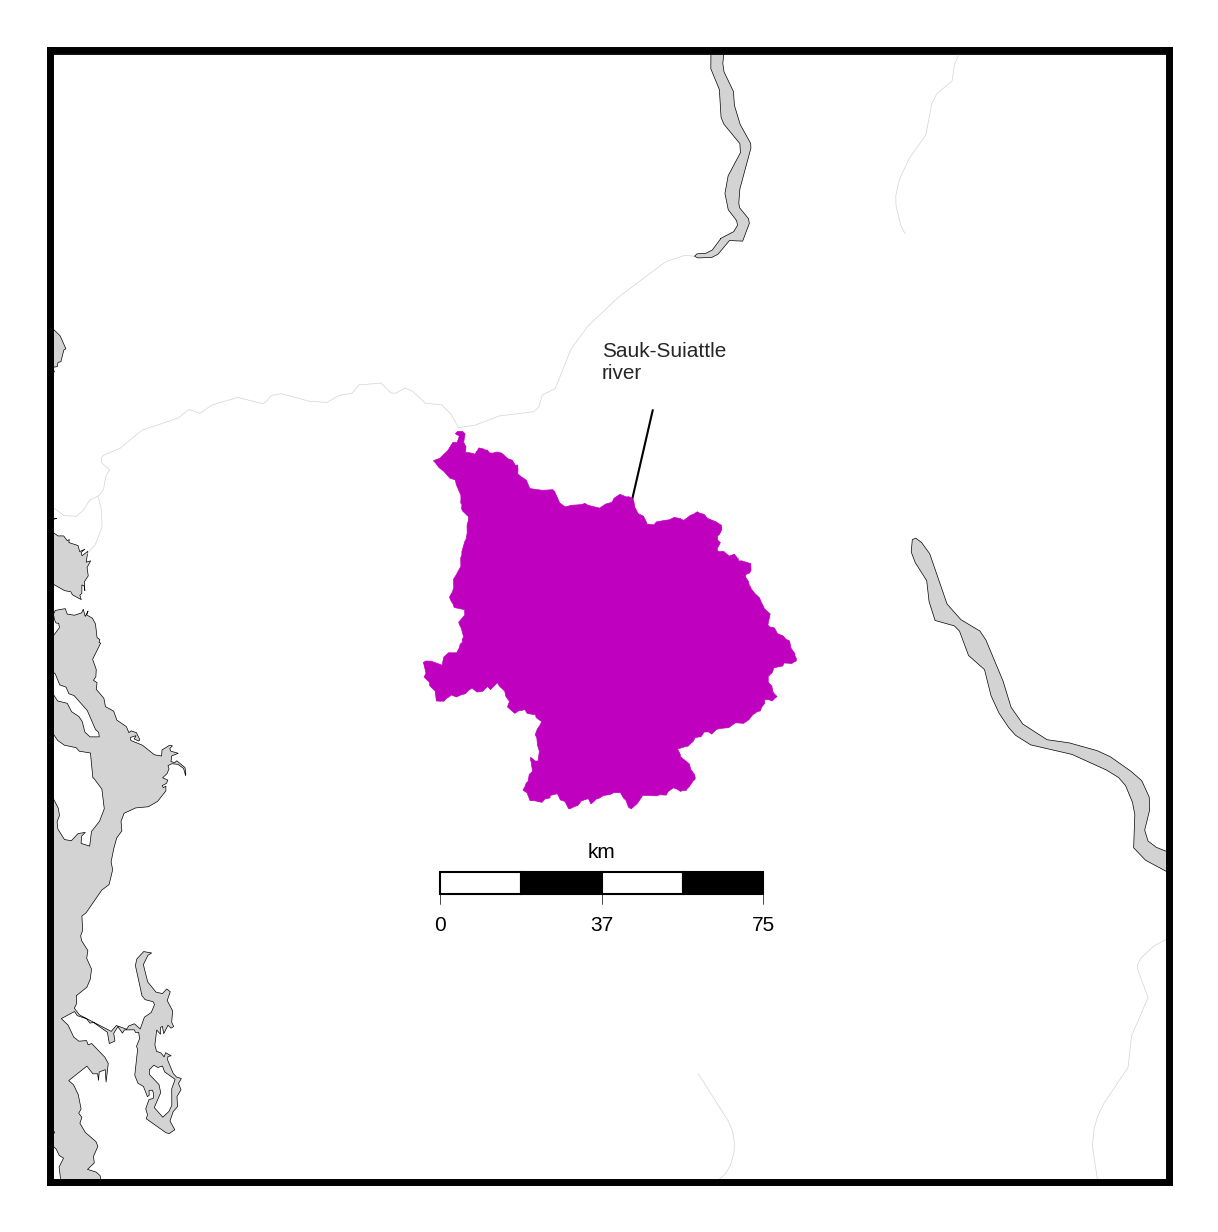

In [6]:
v1 = ogh.multiSiteVisual(listOfShapefiles=[sauk], 
                         listOfNames=['Sauk-Suiattle river'],
                         multishape='eachwatershed.shp', 
                         singleshape='allwatersheds.shp', 
                         fileoutpath='sauk_annotated_map.png',
                         projection='merc', epsg=3857, polygon_color='m', margin=1, 
                         scale_x_dist=0, scale_y_dist=-0.35, scale_ref_length=75, scale_yoffset=5000,
                         text_x_dist=0, text_y_dist=0.35)

## Visualize all study sites upon the landscape

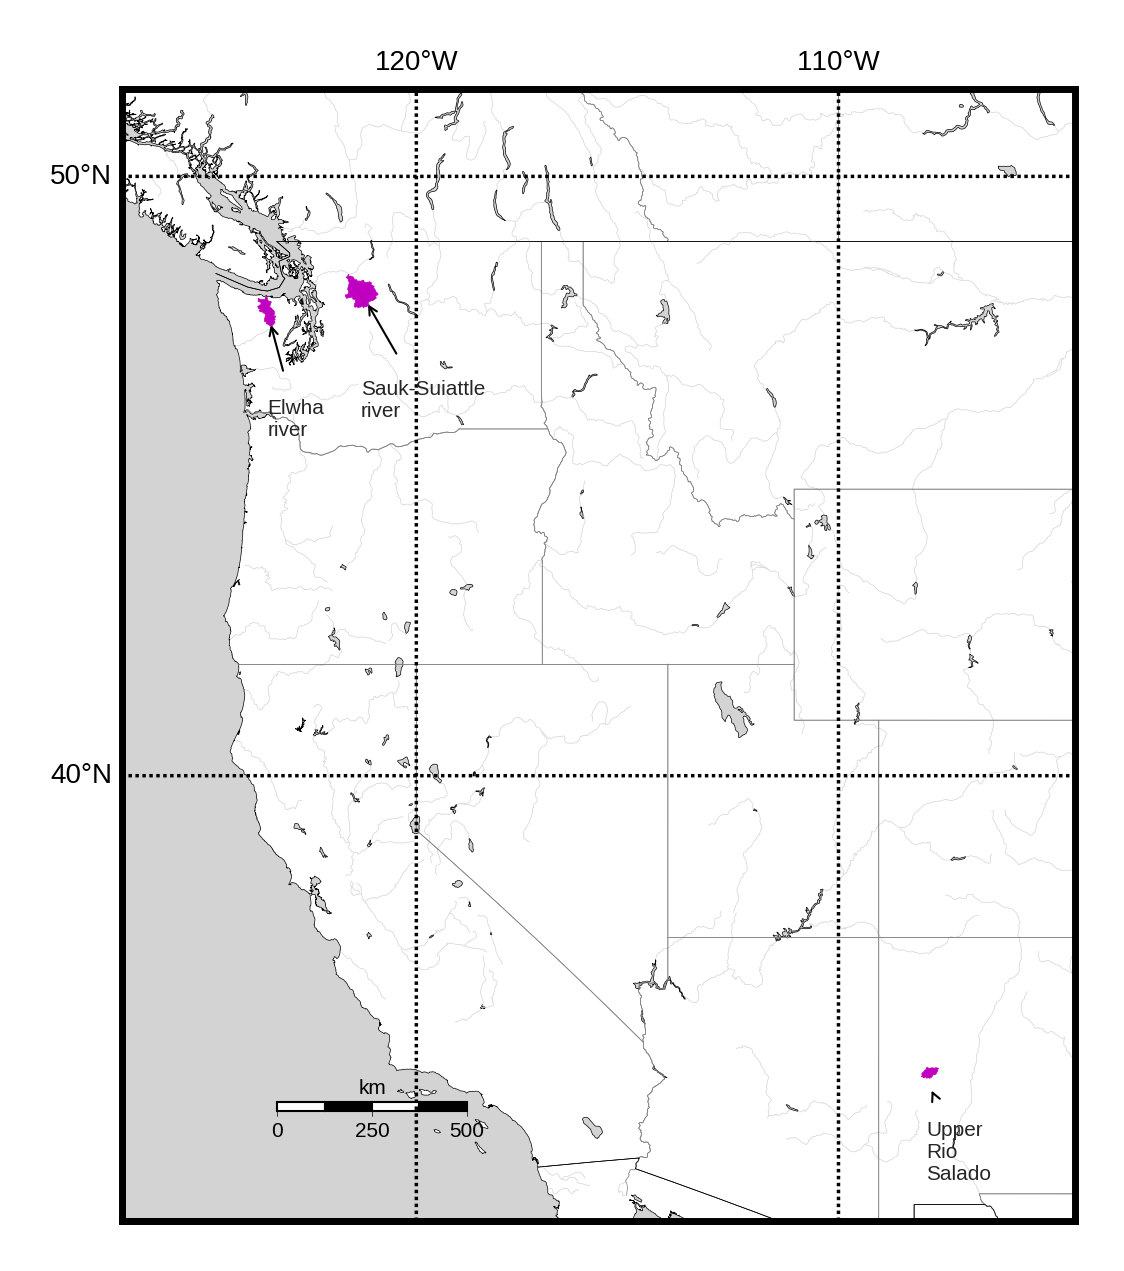

In [7]:
annotated_map = os.path.join(homedir, 'all_annotated_map.png')

v2 = ogh.multiSiteVisual(listOfShapefiles=[sauk, elwha, riosalado],
                         listOfNames=['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                         multishape=os.path.join(homedir, 'eachwatershed.shp'),
                         singleshape=os.path.join(homedir, 'allwatersheds.shp'),
                         fileoutpath=annotated_map,
                         projection='merc', epsg=3857, polygon_color='m', margin=0.2, 
                         scale_x_dist=-1, scale_y_dist=-12.5, scale_ref_length=500, scale_yoffset=25000,
                         text_x_dist=0, text_y_dist=-2)

# 4. Map Gridded Cell Centroids that intersect with the watersheds of interest

In [8]:
%%time 
# Generate list of stations to download
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                              mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))
print(mappingfile1)


mappingfile2=ogh.treatgeoself(shapefile=elwha, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'Elwha_mappingfile.csv'))
print(mappingfile2)


mappingfile3=ogh.treatgeoself(shapefile=riosalado, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'RioSalado_mappingfile.csv'))
print(mappingfile3)

(99, 4)
   FID       LAT      LONG_    ELEV
0    0  48.53125 -121.59375  1113.0
1    1  48.46875 -121.46875   646.0
2    2  48.46875 -121.53125   321.0
3    3  48.46875 -121.59375   164.0
4    4  48.46875 -121.65625   369.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/Sauk_mappingfile.csv
(55, 4)
   FID       LAT      LONG_   ELEV
0    0  48.15625 -123.53125   36.0
1    1  48.15625 -123.59375   58.0
2    2  48.15625 -123.71875   97.0
3    3  48.09375 -123.40625  174.0
4    4  48.09375 -123.46875  229.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/Elwha_mappingfile.csv
(31, 4)
   FID       LAT      LONG_    ELEV
0    0  34.53125 -107.65625  2052.0
1    1  34.53125 -107.71875  2217.0
2    2  34.53125 -107.78125  2231.0
3    3  34.53125 -107.84375  2297.0
4    4  34.53125 -107.90625  2395.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c

## Visualize the gridded cell elevation gradient of each study site

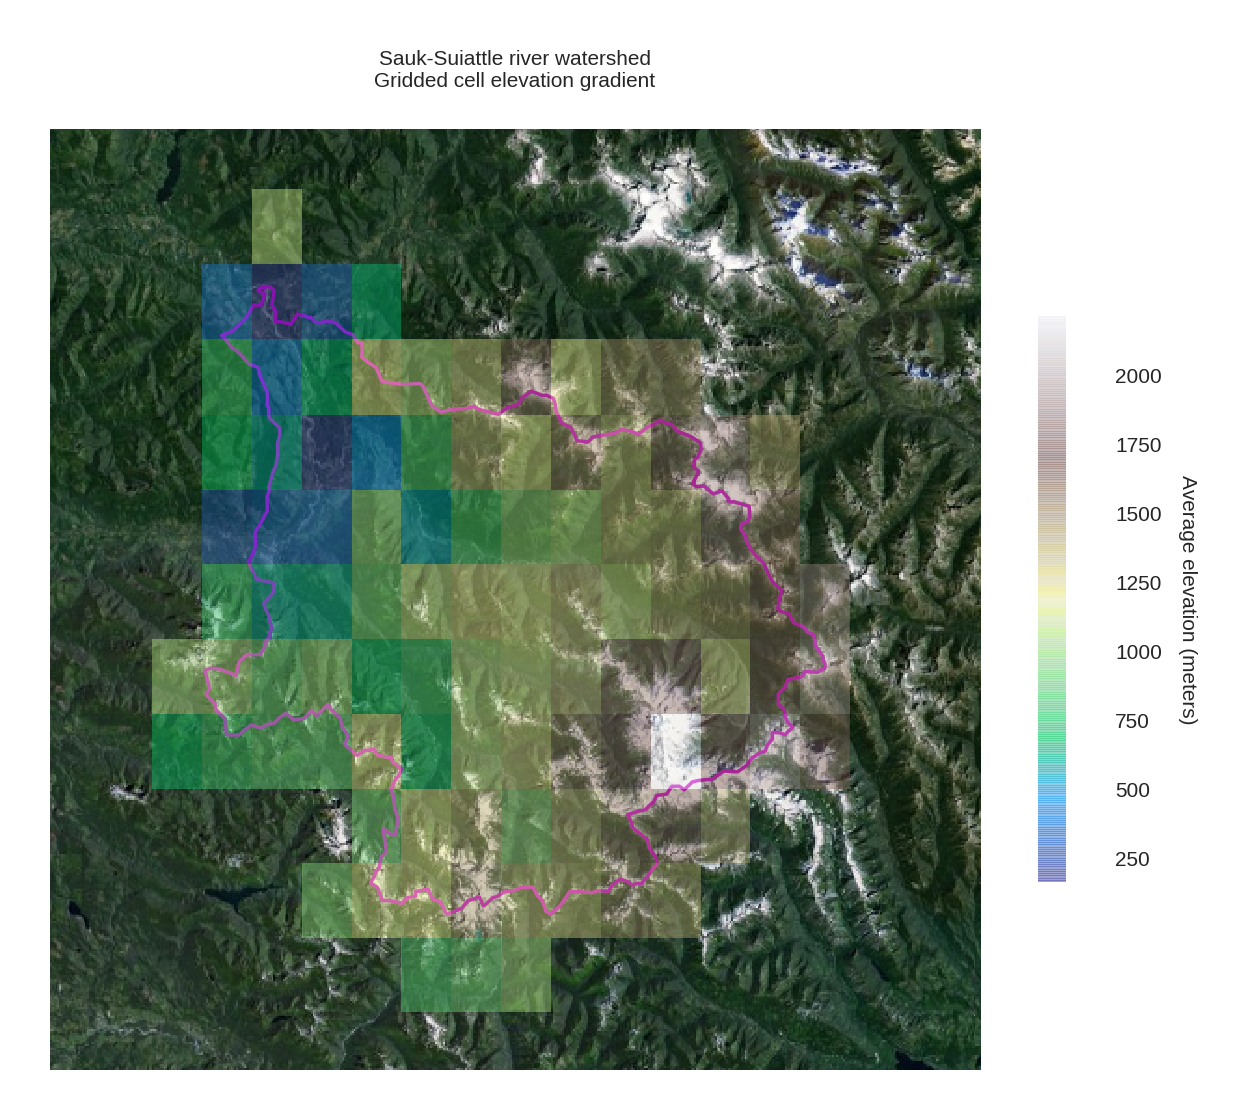

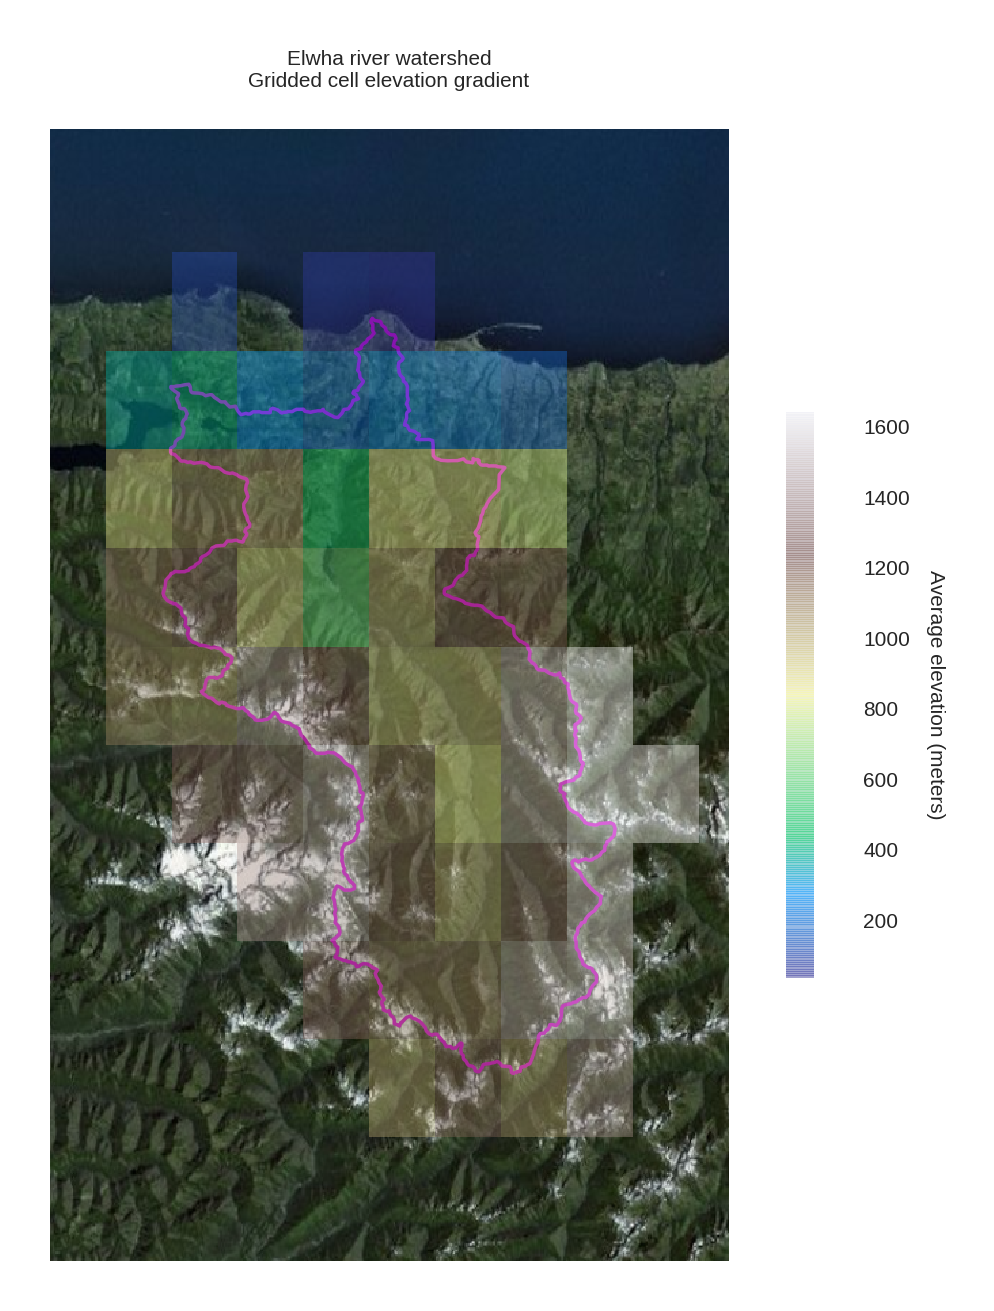

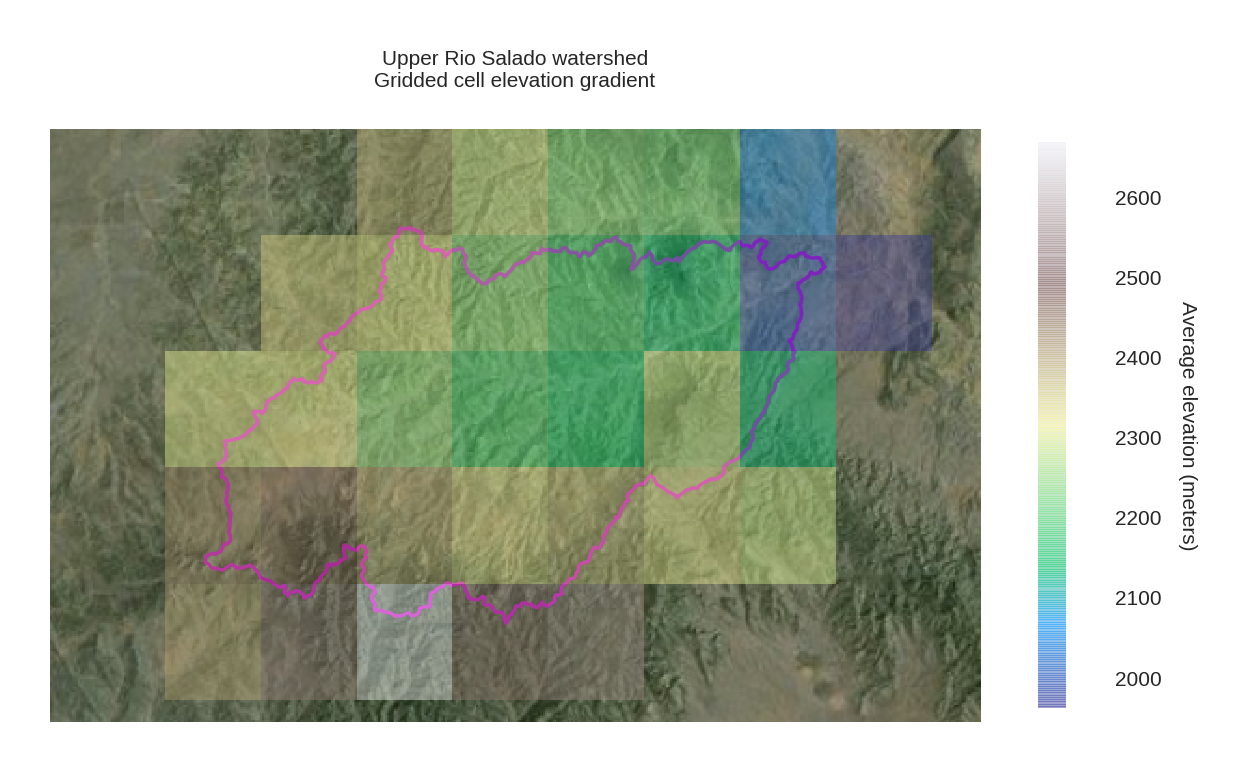

CPU times: user 49.9 s, sys: 3.71 s, total: 53.6 s
Wall time: 56.6 s


In [9]:
%%time 
# plot the watershed elevation gradient

for mappingfile, shp, sitename, outfilename in zip([mappingfile1, mappingfile2, mappingfile3],
                                                   [sauk, elwha, riosalado],
                                                   ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                                                   ['gcGradient_s.png','gcGradient_e.png','gcGradient_r.png']):

    # generate gridded Cell Gradient for the mappingfile ELEV variable
    ogh.griddedCellGradient(mappingfile=mappingfile, 
                            shapefile=shp,
                            outfilepath=os.path.join(homedir, outfilename),
                            plottitle='{0} watershed\nGridded cell elevation gradient'.format(sitename),
                            colorbar_label='Average elevation (meters)',
                            spatial_resolution=1/16, margin=0.25, epsg=3857, column='ELEV',
                            basemap_image='ESRI_Imagery_World_2D', cmap='terrain')


## 5. Save results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

## Archive the downloaded data files for collaborative use

Create list of files to save to HydroShare. Verify location and names.

In [10]:
# mappingfiles
mappingfile1 # sauk
mappingfile2 # elwha
mappingfile3 # riosalado

# Multisite Map
annotated_map 

# Elevation gradient maps
sauk_gcG = os.path.join(homedir, 'gcGradient_s.png')
elwha_gcG = os.path.join(homedir, 'gcGradient_e.png')
riosalado_gcG = os.path.join(homedir, 'gcGradient_r.png')

In [ ]:
# Prepare for new HydroShare Generic Resource
title = 'TreatGeoSelf to study site mapping files'
abstract = 'These mapping files contain the 1/16-degree gridded cell centroids for each study site of interest. Each csv file was generated from intersecting the 1/16-degree Contiguous United States gridded cell centroids with the study site polygon shapefile. The mapping files describe each gridded cell as a row, the longitude (LONG_) and latitude (LAT) coordinates to five decimal digits, and the average elevation of each gridded cell area. The gridded cell gradients from each mapping file was rendered onto an ESRI Image World 2D basemap for visual reference.'
keywords = ['Sauk', 'Elwha','Rio Salado','gridded cell gradients','climate','hydromet','watershed'] 
rtype = 'genericresource'

# Files to migrate
files=[mappingfile1, mappingfile2, mappingfile3, annotated_map, sauk_gcG, elwha_gcG, riosalado_gcG]

# Create the new resource
resource_id = hs.createHydroShareResource(title=title,
                                          abstract=abstract, 
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)